In [1]:
import numpy as np
import pandas as pd
import os
import glob
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

In [ ]:
# 20250313: PD, scRNA-seq, cell-type splitted and pooled, MitoSAlt(last only)
# 1. Fitting model using assumed base error derived call (heteroplasmy < 1%)
# 2. Remove deletions with few support reads (WT read = 0 or del read = 1)
# 3. Filter based on Beta-binomial model, with q-score

In [2]:
# ==== Calculate p value by Beta-Binomial model ====
def beta_binomial_pval(total_depth, alt_depth, alpha, beta):
    """
    Calculate P value using Beta-Binomial model
    - Find the probability that del read > alt_depth
    """
    return 1 - stats.betabinom.cdf(alt_depth - 1, total_depth, alpha, beta)

In [3]:
### Down sample to 50 cells
# /home/hrknkg/mitosalt/250319_pdrna_neuronsub/2_result

tsv_files = glob.glob(os.path.join(os.getcwd(), "./2_result/*.tsv"))
dataframes = []

for file in tsv_files:
    data = pd.read_csv(file, sep='\t')
    dataframes.append(data)
df = pd.concat(dataframes, ignore_index=True)

# split name & labeling & total depth calculation
df[['sample', 'cluster']] = df['name'].str.split('.', expand=True)[[0, 1]]
df['pt'] = df['sample'].apply(lambda x: 'wt' if 'c' in x else ('pd' if 'p' in x else 'other'))
df["total_depth"] = df["delread"] + df["wtread"]

print(df.head())

                 name  break5  break3  delread  wtread  heteroplasmy  \
0  p103_m68.Astrocyte    5202    5299        2      96      2.040816   
1  p103_m68.Astrocyte    3205   12011        1      98      1.010101   
2  p103_m68.Astrocyte     686    3984        1     170      0.584795   
3  p103_m68.Astrocyte    2076    3850        2     252      0.787402   
4  p103_m68.Astrocyte    3843    3960        1      20      4.761905   

     sample    cluster  pt  total_depth  
0  p103_m68  Astrocyte  pd           98  
1  p103_m68  Astrocyte  pd           99  
2  p103_m68  Astrocyte  pd          171  
3  p103_m68  Astrocyte  pd          254  
4  p103_m68  Astrocyte  pd           21  


In [4]:
df0 = df.copy()
row_count = len(df)
print(f"1_all_row: {row_count}")

1_all_row: 10757


In [5]:
# ====== Parameter estimation with a method of moments ======

# Assuming heteroplasmy < 1 is from base error
be_df = df[df["heteroplasmy"] < 1] 
total_depths = be_df["total_depth"]
alt_depths = be_df["delread"]

row_count3 = len(be_df)
print(f"3_base_error_row: {row_count3}")

3_base_error_row: 5563


In [6]:
# Calculate mean and variance of error
error_rates = alt_depths / total_depths
mean_error = np.mean(error_rates)
var_error = np.var(error_rates)

# Estimate α, β (Beta-distribution) by a method of moments
alpha = mean_error * ((mean_error * (1 - mean_error) / var_error) - 1)
beta = (1 - mean_error) * ((mean_error * (1 - mean_error) / var_error) - 1)
print(f"Estimated beta distribution parameter: alpha={alpha:.3f}, beta={beta:.3f}")

Estimated beta distribution parameter: alpha=3.889, beta=788.581


In [7]:
# ====== Remove deletions with few support reads (WT read = 0 or del read = 1) ======
df = df.loc[(df['wtread'] != 0) & (df['delread'] != 1)]
row_count2 = len(df)
print(f"2_filtered_row(WT read = 0 or del read = 1): {row_count2}")

2_filtered_row(WT read = 0 or del read = 1): 4535


In [8]:
# Calculate and append p value col
df["p_value"] = df.apply(lambda row: beta_binomial_pval(row["total_depth"], row["delread"], alpha, beta), axis=1)
df.head()

,name,break5,break3,delread,wtread,heteroplasmy,sample,cluster,pt,total_depth,p_value
0,p103_m68.Astrocyte,5202,5299,2,96,2.040816,p103_m68,Astrocyte,pd,98,0.092278
3,p103_m68.Astrocyte,2076,3850,2,252,0.787402,p103_m68,Astrocyte,pd,254,0.341044
7,p103_m68.Astrocyte,775,12007,2,253,0.784314,p103_m68,Astrocyte,pd,255,0.342543
9,p103_m68.Astrocyte,1373,6582,2,63,3.076923,p103_m68,Astrocyte,pd,65,0.046692
12,p103_m68.Astrocyte,1380,2131,3,222,1.333333,p103_m68,Astrocyte,pd,225,0.120044


In [9]:
# Calculate q value with Benjamini-Hochberg
df["q_value"] = multipletests(df["p_value"], method="fdr_bh")[1]
df.head()

,name,break5,break3,delread,wtread,heteroplasmy,sample,cluster,pt,total_depth,p_value,q_value
0,p103_m68.Astrocyte,5202,5299,2,96,2.040816,p103_m68,Astrocyte,pd,98,0.092278,0.200231
3,p103_m68.Astrocyte,2076,3850,2,252,0.787402,p103_m68,Astrocyte,pd,254,0.341044,0.459761
7,p103_m68.Astrocyte,775,12007,2,253,0.784314,p103_m68,Astrocyte,pd,255,0.342543,0.460822
9,p103_m68.Astrocyte,1373,6582,2,63,3.076923,p103_m68,Astrocyte,pd,65,0.046692,0.129588
12,p103_m68.Astrocyte,1380,2131,3,222,1.333333,p103_m68,Astrocyte,pd,225,0.120044,0.238563


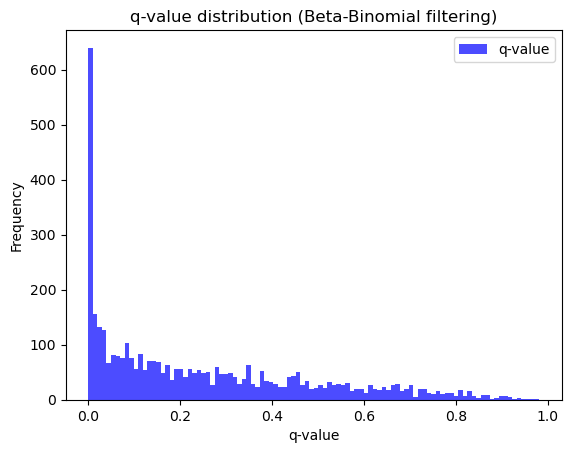

In [31]:
# q value distribution
plt.hist(df["q_value"], bins=100, alpha=0.7, color="blue", label="q-value")
plt.xlabel("q-value")
plt.ylabel("Frequency")
plt.legend()
plt.title("q-value distribution (Beta-Binomial filtering)")
plt.show()

In [10]:
# Save data
df.to_csv('250319_pdrna_ds50_betabinomial.tsv', sep='\t', index=False)